In [35]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")


In [36]:
# Load dataset and filter for wildfire-exposed regions with complete data
data = pd.read_csv("../10_Data_Clean/xgboost_data.csv") # add your directory for the data

In [37]:
data.head(3)

,Median_Household_Income,Total_Population,PRICE,Avg_Household_Size,Gini_Index,ZIP_CODE,YEAR,Employment_Rate,Below_Poverty_Rate,Rate_College_or_Higher,...,FIRE_LAST_YEAR,FIRE_SHOCK,YEAR_OF_LAST_FIRE,YEARS_SINCE_LAST_FIRE,CUMULATIVE_ACRES_BURNED_LAST_3YRS,FIRE_EXPOSED_x_PRICE_CHANGE_LAG1,MAX_PCT_ZIP_BURNED_x_ROLLING_1yr_PRICE_CHANGE,FIRE_EXPOSED_x_Median_Household_Income,FIRE_EXPOSED_x_Below_Poverty_Rate,ROLLING_3yr_PRICE_CHANGE_STD
0,35658.0,54480,263100.0,4.24,0.4056,90001,2012,89.369276,30.632127,16.684648,...,0,0,NaN,-1.0,0.0,NaN,NaN,0.0,0.0,0.000000
1,35097.0,54760,249600.0,4.23,0.4108,90001,2013,87.745738,32.055698,17.057243,...,0,0,NaN,-1.0,0.0,-0.0,NaN,0.0,0.0,0.000000
2,34050.0,56314,241800.0,4.22,0.4181,90001,2014,87.023960,33.644361,18.102684,...,0,0,NaN,-1.0,0.0,-0.0,NaN,0.0,0.0,1.418547


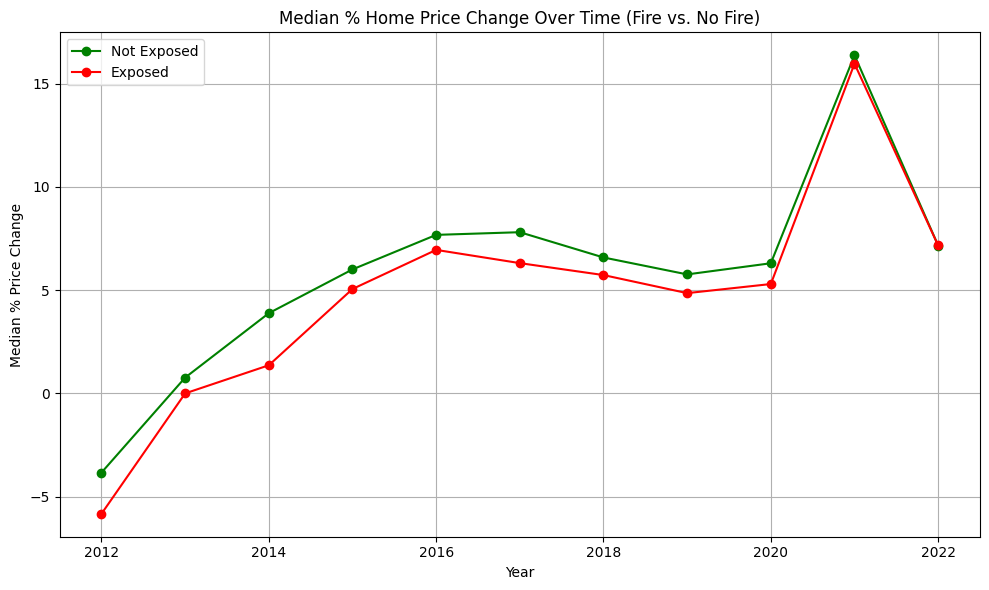

In [38]:
########################################################## Create a line plot showing average % price change per year, comparing ZIP codes ############################################


# Step 1: Group by YEAR and FIRE_EXPOSED, take mean of percent price change
avg_price_change = data.groupby(['YEAR', 'FIRE_EXPOSED'])['PCT_PRICE_CHANGE (%)'].median().reset_index()

# Step 2: Pivot table
pivot_df = avg_price_change.pivot(index='YEAR', columns='FIRE_EXPOSED', values='PCT_PRICE_CHANGE (%)')

# Step 3: Plot with explicit conversion to numpy arrays
plt.figure(figsize=(10, 6))
plt.plot(pivot_df.index.to_numpy(), pivot_df[0].to_numpy(), label='Not Exposed', marker='o', color='green')
plt.plot(pivot_df.index.to_numpy(), pivot_df[1].to_numpy(), label='Exposed', marker='o', color='red')
plt.title('Median % Home Price Change Over Time (Fire vs. No Fire)')
plt.xlabel('Year')
plt.ylabel('Median % Price Change')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


For each year (2012–2018), it plots the median percentage change in home prices for:
ZIP codes not exposed to fire (green line)
ZIP codes exposed to fire (red line)
What to notice:

Home prices are rising in both groups, but:
The red line (exposed) tends to grow more slowly — i.e., wildfires may dampen home price appreciation.

      Not Exposed  Exposed  Difference (Not - Exposed)
YEAR                                                  
2012        -3.83    -5.83                        2.00
2013         0.76     0.00                        0.76
2014         3.88     1.36                        2.52
2015         6.00     5.05                        0.95
2016         7.67     6.95                        0.73
2017         7.80     6.31                        1.50
2018         6.58     5.73                        0.85
2019         5.76     4.85                        0.91
2020         6.30     5.29                        1.01
2021        16.37    15.96                        0.41
2022         7.16     7.16                       -0.00


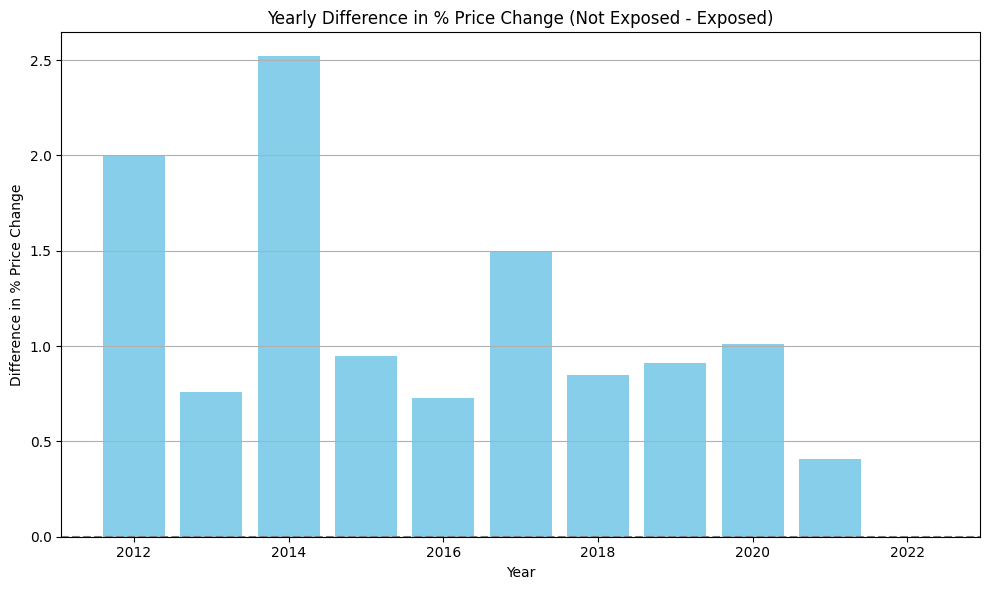

In [39]:
########################### Summary Table of Differences Per Year #############################

# Step 1: Group by year and exposure, and calculate the mean price change
grouped = data.groupby(['YEAR', 'FIRE_EXPOSED'])['PCT_PRICE_CHANGE (%)'].median().unstack()

# Step 2: Rename columns for clarity
grouped.columns = ['Not Exposed', 'Exposed']

# Step 3: Create a new column for the difference
grouped['Difference (Not - Exposed)'] = grouped['Not Exposed'] - grouped['Exposed']

# Step 4: Optional - Round the results for presentation
summary_table = grouped.round(2)

print(summary_table)

############################# Visualise the difference with a bar chart #############################

# Make sure YEAR is the index
summary_table.reset_index(inplace=True)

plt.figure(figsize=(10, 6))
plt.bar(summary_table['YEAR'], summary_table['Difference (Not - Exposed)'], color='skyblue')
plt.axhline(0, color='gray', linestyle='--')

plt.title('Yearly Difference in % Price Change (Not Exposed - Exposed)')
plt.xlabel('Year')
plt.ylabel('Difference in % Price Change')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


For each year, the difference in price growth between not-exposed and exposed ZIPs:
`Difference = Median Price Change (Not Exposed) − Median Price Change (Exposed)`

What to notice:

All bars are positive, meaning non-exposed ZIPs had higher price growth every year.
The difference peaked in 2014 (2.11%), suggesting that year had the strongest fire-related negative impact on housing prices.


In [40]:
#####################################
# T-test
####################################

import pandas as pd
from scipy import stats

# 1. Make sure your DataFrame is loaded, e.g.
# data = pd.read_csv('your_data.csv')

# 2. Loop over each year and perform Welch’s t-test
results = []
for year, grp in data.groupby('YEAR'):
    not_exp = grp.loc[grp['FIRE_EXPOSED'] == 0, 'PCT_PRICE_CHANGE (%)']
    exp = grp.loc[grp['FIRE_EXPOSED'] == 1, 'PCT_PRICE_CHANGE (%)']

    # drop any NaNs just in case
    not_exp = not_exp.dropna()
    exp     = exp.dropna()

    t_stat, p_val = stats.ttest_ind(not_exp, exp, equal_var=False)
    results.append({
        'YEAR': year,
        't_stat': t_stat,
        'p_value': p_val
    })

# 3. Collect into a DataFrame for easy viewing
ttest_df = pd.DataFrame(results).sort_values('YEAR')
print(ttest_df)


    YEAR    t_stat   p_value
0   2012  1.075417  0.283866
1   2013 -0.102929  0.918150
2   2014  0.964198  0.337052
3   2015  1.497424  0.136547
4   2016  0.439441  0.660872
5   2017  3.077479  0.002269
6   2018  3.148720  0.001817
7   2019  1.826479  0.069245
8   2020  1.407027  0.160497
9   2021 -0.301637  0.763270
10  2022 -0.277812  0.781564


In [41]:
from scipy import stats

# Subset the two groups over the entire dataset
not_exp_all = data.loc[data['FIRE_EXPOSED'] == 0, 'PCT_PRICE_CHANGE (%)']
exp_all     = data.loc[data['FIRE_EXPOSED'] == 1, 'PCT_PRICE_CHANGE (%)']

# Welch’s t-test (doesn't assume equal variances)
t_stat_all, p_val_all = stats.ttest_ind(not_exp_all, exp_all, equal_var=False)

print(f"Overall t = {t_stat_all:.3f}, p = {p_val_all:.3f}")


Overall t = 4.206, p = 0.000


In [42]:
import statsmodels.formula.api as smf

# add YEAR as a categorical (fixed effect)
data['YEAR'] = data['YEAR'].astype(str)
model = smf.ols("Q('PCT_PRICE_CHANGE (%)') ~ FIRE_EXPOSED + C(YEAR)", data).fit()
print(model.summary().tables[1])


                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.7008      0.264    -17.826      0.000      -5.218      -4.184
C(YEAR)[T.2013]     4.8195      0.373     12.938      0.000       4.089       5.550
C(YEAR)[T.2014]    10.1430      0.375     27.067      0.000       9.408      10.877
C(YEAR)[T.2015]    10.9984      0.375     29.352      0.000      10.264      11.733
C(YEAR)[T.2016]    12.3424      0.375     32.948      0.000      11.608      13.077
C(YEAR)[T.2017]    12.9079      0.376     34.368      0.000      12.172      13.644
C(YEAR)[T.2018]    11.7285      0.375     31.291      0.000      10.994      12.463
C(YEAR)[T.2019]    11.0791      0.375     29.509      0.000      10.343      11.815
C(YEAR)[T.2020]    11.5146      0.332     34.671      0.000      10.864      12.166
C(YEAR)[T.2021]    20.8865      0.332     62.861      0.000      20.235     